In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from tinygrad import Tensor, nn, TinyJit
import numpy as np
import matplotlib.pyplot as plt
from common import word_generator, create_transition_matrix, draw_transition_matrix

In [6]:
names = open("./names.txt").read().splitlines()

In [7]:
empty_char_token = "."
vocab = [empty_char_token] + sorted(set("".join(names)))
vocab_size = len(vocab)

In [8]:
block_size = 4
X, y = [], []

for name in names:
  name_chars = [empty_char_token] * block_size + list(name) + [empty_char_token]
  for i in range(len(name_chars) - block_size):
    X.append([vocab.index(char) for char in name_chars[i : i + block_size]])
    y.append(vocab.index(name_chars[i + block_size]))


split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = (
  Tensor(X[:split]),
  Tensor(y[:split]),
  Tensor(X[split:]),
  Tensor(y[split:]),
)

X_train, y_train, X_test, y_test

(<Tensor <LB METAL (182516, 4) int (<MetaOps.COPY: 3>, None)> on METAL with grad None>,
 <Tensor <LB METAL (182516,) int (<MetaOps.COPY: 3>, None)> on METAL with grad None>,
 <Tensor <LB METAL (45630, 4) int (<MetaOps.COPY: 3>, None)> on METAL with grad None>,
 <Tensor <LB METAL (45630,) int (<MetaOps.COPY: 3>, None)> on METAL with grad None>)

In [9]:
class EmbeddedMLP:
  def __init__(
    self,
    vocab_size,
    embed_size,
    input_size,
    output_size,
    h=[(200, Tensor.tanh), (100, Tensor.tanh)],
  ):
    self.input_size = input_size
    self.layers = [nn.Embedding(vocab_size, embed_size)]
    flattened_embed_size = input_size * embed_size
    self.layers.append(lambda x: x.reshape((-1, flattened_embed_size)))
    prev_layer_size = flattened_embed_size
    for layer_size, layer_activation in h:
      self.layers.append(nn.Linear(prev_layer_size, layer_size))
      self.layers.append(nn.BatchNorm(layer_size))
      self.layers.append(layer_activation)
      prev_layer_size = layer_size
    self.layers.append(nn.Linear(prev_layer_size, output_size))

  def __call__(self, x: Tensor):
    assert len(x.shape) <= 2 and x.shape[-1] == self.input_size
    return x.sequential(self.layers)


embedded_mlp = EmbeddedMLP(
  vocab_size, embed_size=10, input_size=block_size, output_size=vocab_size
)

In [10]:
optim = nn.optim.Adam(nn.state.get_parameters(embedded_mlp))
batch_size = 128


@TinyJit
@Tensor.train()
def train_step():
  optim.zero_grad()
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X_samples, y_samples = X_train[samples], y_train[samples]
  loss = embedded_mlp(X_samples).sparse_categorical_crossentropy(y_samples).backward()
  optim.step()
  return loss

In [11]:
losses = []
for step in range(1, 20001):
  loss = train_step().item()
  losses.append(loss)
  if step == 1 or step % 1000 == 0:
    with Tensor.inference_mode():
      acc = (embedded_mlp(X_test).argmax(axis=1) == y_test).mean().item()
      print(f"step {step}, loss {loss:.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.37, acc 9.85%
step 1000, loss 2.25, acc 26.78%
step 2000, loss 2.23, acc 27.95%
step 3000, loss 2.14, acc 28.20%
step 4000, loss 2.26, acc 28.85%
step 5000, loss 2.29, acc 28.67%
step 6000, loss 2.05, acc 29.23%
step 7000, loss 2.00, acc 29.73%
step 8000, loss 2.06, acc 30.13%
step 9000, loss 2.18, acc 29.61%
step 10000, loss 2.25, acc 30.03%
step 11000, loss 2.06, acc 30.39%
step 12000, loss 1.89, acc 30.54%
step 13000, loss 1.86, acc 30.68%
step 14000, loss 1.87, acc 30.90%
step 15000, loss 1.83, acc 30.70%
step 16000, loss 2.06, acc 30.73%
step 17000, loss 1.94, acc 30.73%
step 18000, loss 1.90, acc 30.95%
step 19000, loss 1.87, acc 31.09%
step 20000, loss 2.09, acc 30.24%


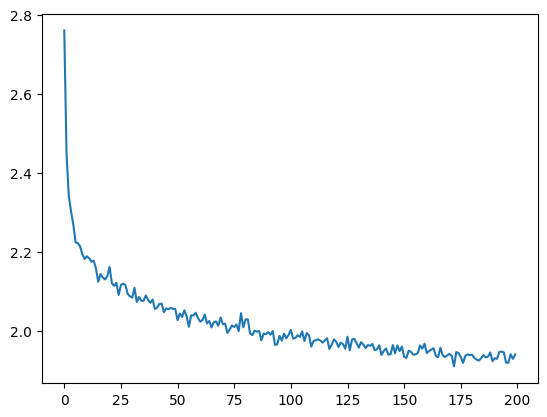

In [12]:
plt.plot(Tensor(losses).reshape(-1, 100).mean(1).numpy());

In [13]:
@word_generator(
  block_size=block_size, empty_char=empty_char_token, max_size=float("inf")
)
def generate_word(prev_block: str):
  with Tensor.inference_mode():
    x = Tensor([vocab.index(char) for char in prev_block])
    y = embedded_mlp(x).squeeze()
    counts = y.exp()
    p = counts / counts.sum()
    return np.random.choice(a=vocab, p=p.numpy())

In [14]:
generated_names = []
for _ in range(32000):
  generated_names.append(generate_word())

generated_names[:1000]

In [ ]:
draw_transition_matrix(
  create_transition_matrix(generated_names, vocab, empty_char_token), vocab
)